# <center>Convex Potential Flow [1]</center>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import gc

from scipy.stats import multivariate_normal
from tqdm.auto import trange
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.distributions.multivariate_normal import MultivariateNormal

from NF_base import *
from training_moons import *

from logdet_estimators import stochastic_logdet_gradient_estimator, unbiased_logdet, stochastic_lanczos_quadrature

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### ICNN

In [3]:
class ConvexQuadratic(nn.Module):
    '''
        Convex Quadratic Layer
        (https://github.com/iamalexkorotin/Wasserstein2Barycenters/blob/cfd2e0d2614ec5d802071ec92076c6e52290215d/src/layers.py#L6)

        Appendix B.2 [1]
        [1] Korotin, Alexander, et al. "Wasserstein-2 generative networks." arXiv preprint arXiv:1909.13082 (2019).
    '''
    __constants__ = ['in_features', 'out_features', 'quadratic_decomposed', 'weight', 'bias']

    def __init__(self, in_features, out_features, bias=True, rank=1):
        super(ConvexQuadratic, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.rank = rank
        
        self.quadratic_decomposed = nn.Parameter(torch.Tensor(
            torch.randn(in_features, rank, out_features)
        ))
        self.weight = nn.Parameter(torch.Tensor(
            torch.randn(out_features, in_features)
        ))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

    def forward(self, input):
        quad = ((input.matmul(self.quadratic_decomposed.transpose(1,0)).transpose(1, 0)) ** 2).sum(dim=1)
        linear = F.linear(input, self.weight, self.bias)
        return quad + linear


class DenseICNN(nn.Module):
    '''
        Fully Conncted ICNN with input-quadratic skip connections
        (https://github.com/iamalexkorotin/Wasserstein2Barycenters/blob/main/src/icnn.py)

        Appendix B.2 [1]
        [1] Korotin, Alexander, et al. "Wasserstein-2 generative networks." arXiv preprint arXiv:1909.13082 (2019).
    '''
    def __init__(
        self, in_dim, 
        hidden_layer_sizes=[32, 32, 32],
        rank=1, activation='celu', dropout=0.03,
        strong_convexity=1e-6
    ):
        super(DenseICNN, self).__init__()
        
        self.strong_convexity = strong_convexity
        self.hidden_layer_sizes = hidden_layer_sizes
        self.droput = dropout
        self.activation = activation
        self.rank = rank
        
        self.quadratic_layers = nn.ModuleList([
            nn.Sequential(
                ConvexQuadratic(in_dim, out_features, rank=rank, bias=True),
                nn.Dropout(dropout)
            )
            for out_features in hidden_layer_sizes
        ])
        
        sizes = zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:])
        self.convex_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(in_features, out_features, bias=False),
                nn.Dropout(dropout)
            )
            for (in_features, out_features) in sizes
        ])
        
        self.final_layer = nn.Linear(hidden_layer_sizes[-1], 1, bias=False)

    def forward(self, input):
        output = self.quadratic_layers[0](input)
        for quadratic_layer, convex_layer in zip(self.quadratic_layers[1:], self.convex_layers):
            output = convex_layer(output) + quadratic_layer(input)
            if self.activation == 'celu':
                output = torch.celu(output)
            elif self.activation == 'softplus':
                output = F.softplus(output)
            elif self.activation == 'relu':
                output = F.relu(output)
            else:
                raise Exception('Activation is not specified or unknown.')
        
        return self.final_layer(output) + .5 * self.strong_convexity * (input ** 2).sum(dim=1).reshape(-1, 1)
    
    def push(self, input):
        """
            Compute the gradient
        """
        output = torch.autograd.grad(
            outputs=self.forward(input), inputs=input,
            create_graph=True, retain_graph=True,
            only_inputs=True,
            grad_outputs=torch.ones((input.size()[0], 1)).cuda().float()
        )[0]
        return output    
    
    def convexify(self):
        """
            Enfore positivity of weights 
            (to have convexity)
        """
        for layer in self.convex_layers:
            for sublayer in layer:
                if (isinstance(sublayer, nn.Linear)):
                    sublayer.weight.data.clamp_(0)
        self.final_layer.weight.data.clamp_(0)
              

In [4]:
def create_ICNN(w=256, d=2, nh=2):
    model = DenseICNN(d, hidden_layer_sizes=[w for k in range(nh)], activation="softplus", 
                      dropout=0, strong_convexity=1e-3)

    # Manual weights init
    for p in model.parameters():
        p.data = torch.randn(p.shape, device='cuda', dtype=torch.float32) / 2.
        
    ## Pretraining for \nabla\psi(x)=x
    X0_sampler = MultivariateNormal(torch.zeros(2, device=device),torch.eye(2,device=device)) 
    # distributions.StandardNormalSampler(dim=2, requires_grad=True)
    D_opt = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.8, 0.9), weight_decay=1e-7)

    model.train(True)
    loss = np.inf

    for iteration in range(10000):
        X = (X0_sampler.sample((500,))).detach() * 4
        X.requires_grad_(True)

        loss = F.mse_loss(model.push(X), X.detach())
        loss.backward()
        D_opt.step(); D_opt.zero_grad()
        model.convexify()

        if loss.item() < 1e-2:
            break

    return model

### Utils

In [5]:
def loss(h,log_det,distr,base_distr="normal"):
    if base_distr == "logistic":
        prior = distr.log_prob(h).sum(1).mean(0)
    else:
        prior = distr.log_prob(h).mean()
    return -(prior+log_det.mean())


def log_likelihood(h,log_det,distr,base_distr="normal"):
    if base_distr == "logistic":
        prior = distr.log_prob(h).sum(1)
    else:
        prior = distr.log_prob(h)
    return prior+log_det


def val_likelihood(model, distr, i, device, base_distr="normal", scatter=False):
    model.eval()
    
    xmin, xmax, ymin, ymax = -8, 8, -8, 8

    xline = torch.linspace(xmin, xmax, 100)
    yline = torch.linspace(ymin, ymax, 100)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    z, log_s = model(xyinput.to(device))
    likelihood = (log_likelihood(z[-1], log_s, distr, base_distr)).exp().cpu()
    zgrid = likelihood.reshape(100,100)

    if scatter:
        z = distr.sample((100,))
        xs = model.backward(z)
        x = xs[-1].detach()
        x = x.cpu().numpy()
        z = z.cpu().numpy()

    plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
    plt.colorbar()
    if scatter:
        plt.scatter(x[:,0],x[:,1],c="red")
        plt.scatter(z[:,0],z[:,1],c="green")
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title('iteration {}'.format(i + 1))
    plt.show()  
    

def true_likelihood(gm):
    xmin, xmax, ymin, ymax = -8, 8, -8, 8
    
    xline = np.linspace(xmin, xmax, 100)
    yline = np.linspace(ymin, ymax, 100)
    xgrid, ygrid = np.meshgrid(xline, yline)
    xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)

    zz = gm.pdf(xyinput)
    zgrid = zz.reshape(100,100)

    plt.contourf(xgrid, ygrid, zgrid, cmap="viridis")
    plt.colorbar()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.show()


In [6]:
def hessian_ICNN(x, nabla_icnn, training):
    n_samples = x.size(0) ## batch_size
    
    nabla_ICNN = nabla_icnn.reshape(n_samples, -1)
    H = []
    for i in range(nabla_ICNN.shape[1]):
        H.append(torch.autograd.grad(nabla_ICNN[:, i].sum(), x, 
                                     create_graph=training, retain_graph=True)[0])

    # H: (batch_size, d, d)
    H = torch.stack(H, dim=1)    
        
    return H


def sample_rademacher(*shape):
    return (torch.rand(*shape) > 0.5).float() * 2 - 1

def log_det_Hessian_approx(x, nabla_icnn, training):
    n_samples, *dims = x.shape
    v = sample_rademacher(n_samples, np.prod(dims)).to(device)
    
    def hvp_fun(v):
        # v is (bsz, dim)
        v = v.reshape(n_samples, *dims)
        hvp = torch.autograd.grad(nabla_icnn, x, v, create_graph=training, retain_graph=True)[0]

        if not torch.isnan(v).any() and torch.isnan(hvp).any():
            raise ArithmeticError("v has no nans but hvp has nans.")
        hvp = hvp.reshape(n_samples, np.prod(dims))
        
        return hvp
    
    est = stochastic_logdet_gradient_estimator(hvp_fun, v, m=np.prod(dims))
    return est


def estimate_log_det(x, nabla_icnn):
    n_samples, *dims = x.shape
    v = torch.nn.functional.normalize(sample_rademacher(n_samples, np.prod(dims)), dim=-1).to(device)
    
    def hvp_fun(v):
        # v is (bsz, dim)
        v = v.reshape(n_samples, *dims)
        hvp = torch.autograd.grad(nabla_icnn, x, v, create_graph=False, retain_graph=True)[0]

        if not torch.isnan(v).any() and torch.isnan(hvp).any():
            raise ArithmeticError("v has no nans but hvp has nans.")
        hvp = hvp.reshape(n_samples, np.prod(dims))
        
        return hvp
    
#     est = unbiased_logdet(hvp_fun, v)
    est = stochastic_lanczos_quadrature(hvp_fun, v, m=np.prod(dims))
    return est


def reverse(icnn, y, max_iter=10000, lr=1.0, tol=1e-12, x=None):
    """
        https://github.com/CW-Huang/CP-Flow/blob/d01303cb4ebeb5a0bbfca638ffaf5b7a8ec22fb1/lib/flows/cpflows.py#L43
    """
    if x is None:
        x = y.clone().detach().requires_grad_(True)

    def closure():
        # Solves x such that f(x) - y = 0
        # <=> Solves x such that argmin_x F(x) - <x,y>
        F = icnn(x)
        loss = torch.sum(F) - torch.sum(x * y)
        x.grad = torch.autograd.grad(loss, x)[0].detach()
        return loss

    optimizer = torch.optim.LBFGS([x], lr=lr, line_search_fn="strong_wolfe", max_iter=max_iter, 
                                  tolerance_grad=tol, tolerance_change=tol)

    optimizer.step(closure)

    torch.cuda.empty_cache()
    gc.collect()

    return x


class ConvexPotentialFlow(BaseNormalizingFlow):
    def __init__(self, icnn, bruteforce=True):
        super().__init__()
        self.icnn = icnn
        self.bruteforce = bruteforce
    
    def forward(self, x):
        x.requires_grad_(True)
        y = self.icnn(x)
        z = torch.autograd.grad(y.sum(), x, retain_graph=True, create_graph=True)[0] ## nabla_ICNN
        
        if self.training:
            ## stochastic estimation of log det H using Rademacher samples
            log_det = log_det_Hessian_approx(x, z, self.training)
        elif self.bruteforce:
            hessian_icnn = hessian_ICNN(x, z, self.training)
            log_det = torch.log(torch.abs(torch.det(hessian_icnn)))
        else:
            ## stochastic estimation of log det H using Lanczos quadrature
            log_det = estimate_log_det(x, z)
        
        if not self.icnn.training:
            z = z.detach()
            log_det = log_det.detach()
        
        return z, log_det
    
    def backward(self, z):
        x = reverse(self.icnn, z)
        return x

### Moons

In [7]:
def train_moons(model, optimizer, n_epochs=10001, base_distr="normal", d=2, 
				device=None, plot_val=True, plot_interval=1000,
                input_grad=False):
    
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    if base_distr == "normal":
        distr = torch.distributions.multivariate_normal.MultivariateNormal(
            torch.zeros(d,device=device),torch.eye(d,device=device))
    elif base_distr == "logistic":
	    distr = TransformedDistribution(Uniform(torch.zeros(d, device=device),
           torch.ones(d, device=device)), SigmoidTransform().inv)
    else:
        raise ValueError("wrong base distribution")

    train_loss = []
    
    pbar = trange(n_epochs)

    for i in pbar: #range(n_epochs):        
        x, y = datasets.make_moons(128, noise=.1)
        x = torch.tensor(x, dtype=torch.float32,requires_grad=input_grad).to(device)

        model.train()

        z, log_det = model(x)
        l = loss(z[-1],log_det,distr,base_distr)

        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        for flow in model.flows:
            if flow.__class__.__name__ == "ConvexPotentialFlow":
                flow.icnn.convexify() # clamp weights to be >=0

        train_loss.append(l.item())
        
        if i%100==0:
            pbar.set_postfix_str(f"loss = {train_loss[-1]:.3f}")

        if plot_val and i % plot_interval == 0:
            model.eval()
            z, log_det = model(x)
            l = loss(z[-1],log_det,distr,base_distr)
            print(i, l.item(), train_loss[-1])
            if input_grad:
                val_moons_grad(model, distr, i, device, base_distr)
            else:
                val_moons(model, distr, i, device, base_distr)
            
    return train_loss

In [8]:
flows = []
for i in range(5):
    icnn = create_ICNN(d=2,w=32,nh=3)
#     flows.append(ActNorm(2))
    flows.append(ConvexPotentialFlow(icnn,bruteforce=False))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3) #, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  12800


0 5.251961708068848 -8.032722473144531


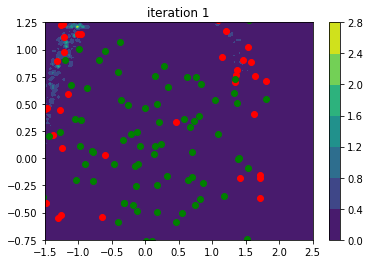

1000 1.0096893310546875 -7.277319431304932


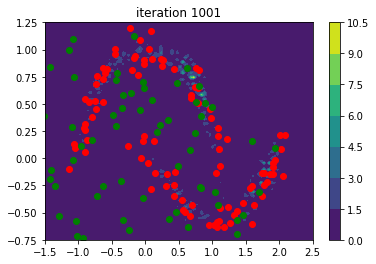

2000 1.0815554857254028 -7.164106845855713


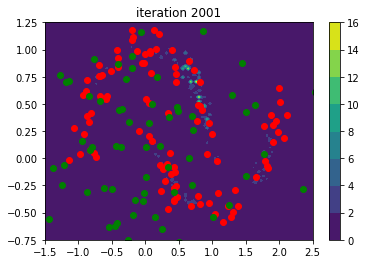

3000 1.0055686235427856 -7.159276008605957


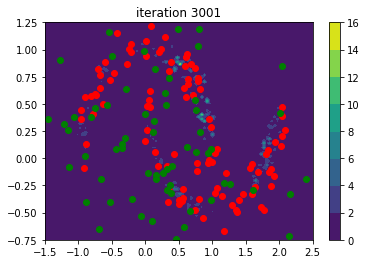

4000 1.0813617706298828 -7.175913333892822


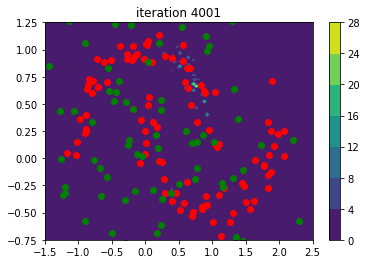

5000 0.9771912097930908 -7.29190731048584


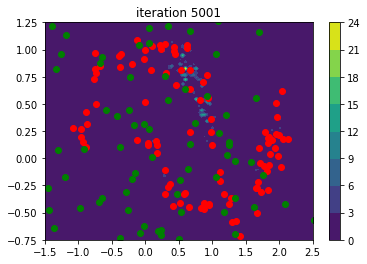

In [9]:
train_loss = train_moons(model,optimizer,n_epochs=5001,base_distr="normal",input_grad=True)

In [10]:
flows = []
for i in range(5):
    icnn = create_ICNN(d=2,w=32,nh=3)
#     flows.append(ActNorm(2))
    flows.append(ConvexPotentialFlow(icnn,bruteforce=True))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3) #, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  12800


0 4.170921325683594 -8.027702331542969


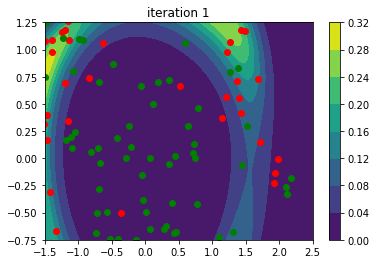

1000 1.14821195602417 -6.998787879943848


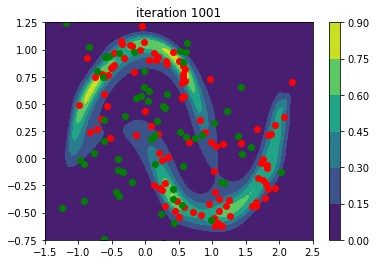

2000 1.089125394821167 -7.253495693206787


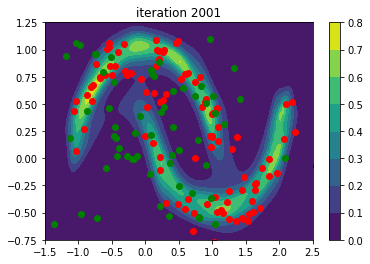

3000 1.0719835758209229 -7.206863880157471


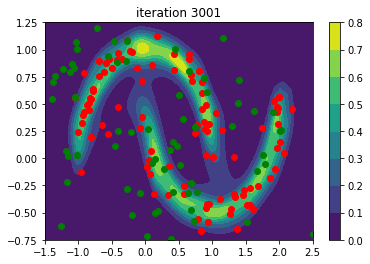

4000 1.0323224067687988 -7.246417045593262


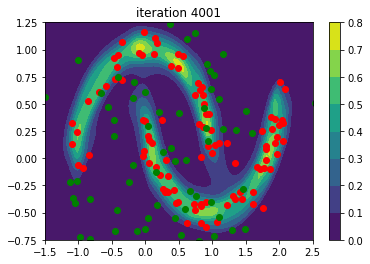

5000 1.0842835903167725 -7.171613693237305


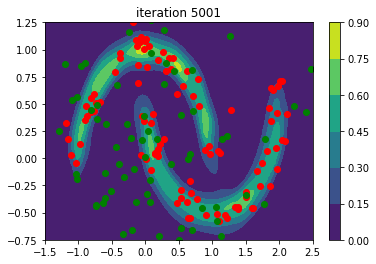

In [11]:
train_loss = train_moons(model,optimizer,n_epochs=5001,base_distr="normal",input_grad=True)

### 8 Gaussians

In [12]:
def create_gaussians(num_points):
    """
        Adapted from https://github.com/rtqichen/ffjord/blob/master/lib/toy_data.py
    """
    scale = 4.
    bias = np.pi / 8
    step = np.pi / 4
    centers = [(np.cos(bias + 0*step), np.sin(bias + 0*step)),
               (np.cos(bias + 1*step), np.sin(bias + 1*step)),
               (np.cos(bias + 2*step), np.sin(bias + 2*step)),
               (np.cos(bias + 3*step), np.sin(bias + 3*step)),
               (np.cos(bias + 4*step), np.sin(bias + 4*step)),
               (np.cos(bias + 5*step), np.sin(bias + 5*step)),
               (np.cos(bias + 6*step), np.sin(bias + 6*step)),
               (np.cos(bias + 7*step), np.sin(bias + 7*step))]
    centers = [(scale * x, scale * y) for x, y in centers]

    dataset = []
    for i in range(num_points):
        point = np.random.randn(2) * 0.5
        idx = np.random.randint(8)
        center = centers[idx]
        point[0] += center[0]
        point[1] += center[1]
        dataset.append(point)
    dataset = np.array(dataset, dtype="float32")
    dataset /= 1.414
    return torch.from_numpy(dataset)

In [13]:
X = create_gaussians(1000)

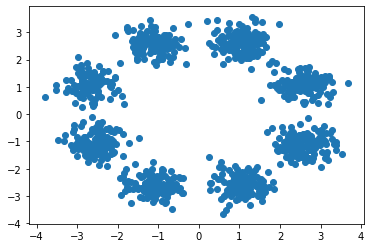

In [14]:
Xnp = X.numpy()
plt.scatter(Xnp[:,0],Xnp[:,1])
plt.show()

In [15]:
train_set = create_gaussians(128000)
test_set = create_gaussians(128000)

In [16]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [17]:
def val_likelihood(model, distr, i, device, base_distr="normal"):
    model.eval()

    xline = torch.linspace(-4, 4, 100)
    yline = torch.linspace(-4, 4, 100)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    xy, log_s = model(xyinput.to(device))
    zz = (log_likelihood(xy[-1],log_s,distr,base_distr)).exp().cpu()
    zgrid = zz.reshape(100,100)

    z = distr.sample((100,))
    xs = model.backward(z)
    x = xs[-1].detach()
    x = x.cpu().numpy()
    z = z.cpu().numpy()

    plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
    plt.colorbar()
    plt.scatter(x[:,0],x[:,1],c="red")
    plt.scatter(z[:,0],z[:,1],c="green")
    plt.xlim(-4,4)
    plt.ylim(-4,4)
    plt.title('iteration {}'.format(i + 1))
    plt.show()


def test_dataloader(model, test_loader, base_distr, device):
    ## Question: mean of means of batchs or mean on all sample?
    model.eval()
    val_loss = []
    for n_batch, data in enumerate(test_loader):
        data = data.to(device)

        z, log_det = model(data)
        l = loss(z[-1], log_det, base_distr)
        val_loss.append(l.item())

    return np.mean(val_loss)



def train_dataloader(model, optimizer, train_loader, test_loader,
                    n_epochs=101, device=None, plot_val=True, plot_interval=5):
    d = 2

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    train_losses = []
    test_losses = []

    pbar = trange(n_epochs)

    for epoch in pbar:
        model.train()

        train_batch = []

        for n_batch, data in enumerate(train_loader):
            data = data.to(device)

            z, log_det = model(data)

            l = loss(z[-1], log_det, base_distr)
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            for flow in model.flows:
                if flow.__class__.__name__ == "ConvexPotentialFlow":
                    flow.icnn.convexify() # clamp weights to be >=0

            train_batch.append(l.item())

        train_losses.append(np.mean(train_batch))

        if epoch % 1 == 0:
            pbar.set_postfix_str(f"loss = {train_losses[-1]:.3f}")

        if plot_val and epoch % plot_interval == 0:
            print(epoch, test_dataloader(model,test_loader,base_distr,device)) # train_loss[-1])
            val_likelihood(model, base_distr, epoch, device)
    
    return train_losses

In [18]:
flows = []
for i in range(5):
    icnn = create_ICNN(d=2,w=32,nh=3)
    flows.append(ConvexPotentialFlow(icnn, bruteforce=False))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3) #, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  12800


0 2.9481082532405853


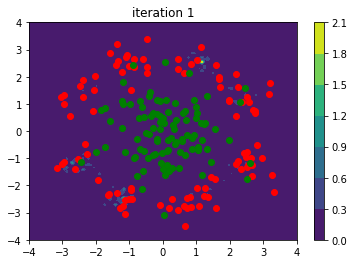

rerolling 1 vectors
5 2.8815634558200838


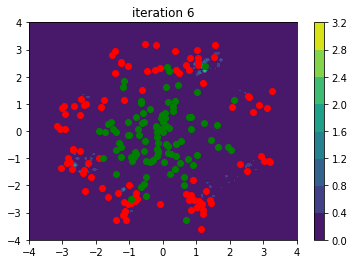

In [19]:
train_loss = train_dataloader(model, optimizer, train_loader, test_loader, n_epochs=6)

In [20]:
flows = []
for i in range(5):
    icnn = create_ICNN(d=2,w=32,nh=3)
    flows.append(ConvexPotentialFlow(icnn, bruteforce=True))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3) #, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  12800


0 2.937802144050598


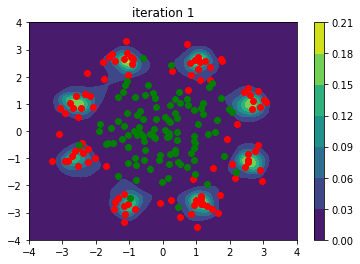

5 2.877567475795746


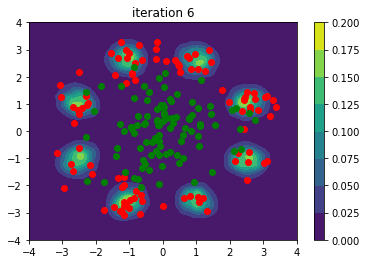

In [21]:
train_loss = train_dataloader(model, optimizer, train_loader, test_loader, n_epochs=6)

### Test Mixture

In [22]:
import torch.distributions as D

random_state = 42
torch.manual_seed(random_state)

d = 2
M = 5
l = 10

p = torch.ones(M)/M
mus = -l/2 + l * torch.rand((M,d), dtype=torch.float32, device=device)
sigmas = [torch.eye(d, device=device, dtype=torch.float32) for i in range(M)]

mix = D.Categorical(p.to(device))
comp = D.Independent(D.Normal(mus,torch.ones(M,2,device=device)),1)

gm = D.MixtureSameFamily(mix, comp)

In [23]:
def val_moons_grad(model, distr, i, device, base_distr="normal"):
    model.eval()

    xline = torch.linspace(-10, 10, 100, requires_grad=True)
    yline = torch.linspace(-10, 10, 100, requires_grad=True)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    xy, log_s = model(xyinput.to(device))
    with torch.no_grad():
	    zz = (log_likelihood(xy[-1],log_s,distr,base_distr)).exp().cpu()
	    zgrid = zz.reshape(100,100)

	    z = distr.sample((100,))
	    xs = model.backward(z)
	    x = xs[-1].detach()
	    x = x.cpu().numpy()
	    z = z.detach().cpu().numpy()

    xgrid = xgrid.detach().cpu().numpy()
    ygrid = ygrid.detach().cpu().numpy()
    zgrid = zgrid.detach().cpu().numpy()

    plt.contourf(xgrid, ygrid, zgrid)
    plt.colorbar()
#     plt.scatter(x[:,0],x[:,1],c="red")
#     plt.scatter(z[:,0],z[:,1],c="green")
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.title('iteration {}'.format(i + 1))
    plt.show() 

In [24]:
def train_mixture(model, optimizer, n_epochs=10001, base_distr="normal", d=2, 
				device=None, plot_val=True, plot_interval=1000,
                input_grad=False):
    
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    if base_distr == "normal":
        distr = torch.distributions.multivariate_normal.MultivariateNormal(
            torch.zeros(d,device=device),torch.eye(d,device=device))
    elif base_distr == "logistic":
	    distr = TransformedDistribution(Uniform(torch.zeros(d, device=device),
           torch.ones(d, device=device)), SigmoidTransform().inv)
    else:
        raise ValueError("wrong base distribution")

    train_loss = []
    
    pbar = trange(n_epochs)

    for i in pbar: #range(n_epochs):               
        x = gm.sample((128,))

        model.train()

        z, log_det = model(x)
        l = loss(z[-1],log_det,distr,base_distr)

        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        for flow in model.flows:
            if flow.__class__.__name__ == "ConvexPotentialFlow":
                flow.icnn.convexify() # clamp weights to be >=0

        train_loss.append(l.item())
        
        if i%100==0:
            pbar.set_postfix_str(f"loss = {train_loss[-1]:.3f}")

        if plot_val and i % plot_interval == 0:
            model.eval()
            z, log_det = model(x)
            l = loss(z[-1],log_det,distr,base_distr)
            print(i, l.item(), train_loss[-1])
            if input_grad:
                val_moons_grad(model, distr, i, device, base_distr)
            else:
                val_moons(model, distr, i, device, base_distr)
            
    return train_loss

In [25]:
flows = []
for i in range(5):
    icnn = create_ICNN(d=2,w=32,nh=3)
    flows.append(ConvexPotentialFlow(icnn, bruteforce=False))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3) #, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  12800


0 7.927165985107422 1.1777162551879883


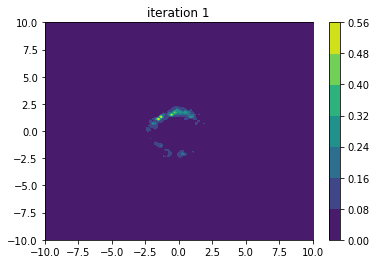

1000 3.8970606327056885 -7.342068195343018


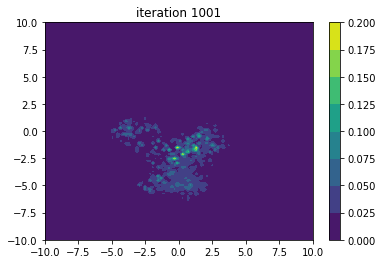

2000 4.011630058288574 -7.265365123748779


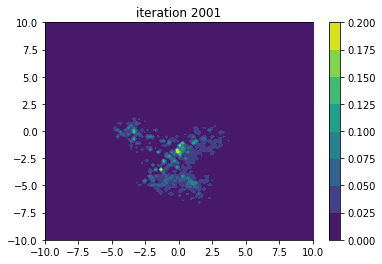

3000 4.108541488647461 -6.8784637451171875


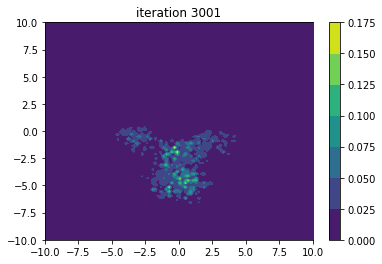

4000 3.9911088943481445 -7.133266448974609


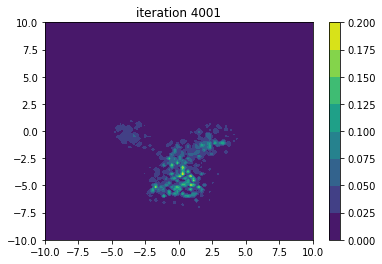

5000 4.090768814086914 -7.069861888885498


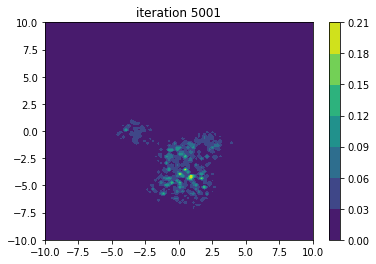

In [26]:
train_loss = train_mixture(model, optimizer, n_epochs=5001, input_grad=True)

In [27]:
def log_likelihood(z, log_det, device):
    """
        Log likelihood
        Inputs:
        - z
        - $\log|\det J_T(z)| = -\log|\det J_{T^{-1}}(x)|$
    """
    d = z.size(1)
    base_distr = D.MultivariateNormal(torch.zeros(d,device=device),torch.eye(d,device=device))
    prior = base_distr.log_prob(z)
    return prior-log_det

def symKL(rho, distr, n_samples, device):
    rho.eval()

    x1 = distr.sample((n_samples,))
    logprob_distr_x1 = distr.log_prob(x1).detach().cpu()

    z, log_det = rho(x1)
    logprob_rho_x1 = log_likelihood(z[-1], -log_det, device).detach().cpu()


    z = torch.randn(n_samples, z[-1].size(1), device=device)
    x2 = rho.backward(z)
    x2 = x2[-1]
    _, log_det = rho(x2)
    logprob_rho_x2 = log_likelihood(z, -log_det, device).detach().cpu()
    logprob_distr_x2 = distr.log_prob(x2).detach().cpu()

    s = torch.mean(logprob_distr_x1-logprob_rho_x1) + torch.mean(logprob_rho_x2-logprob_distr_x2)
    return s

In [28]:
s = symKL(model, gm, 10000, device)
print(s, np.log10(s))

tensor(0.0361) tensor(-1.4426)


In [29]:
flows = []
for i in range(5):
    icnn = create_ICNN(d=2,w=32,nh=3)
    flows.append(ConvexPotentialFlow(icnn, bruteforce=True))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3) #, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  12800


0 7.006006240844727 -1.228036880493164


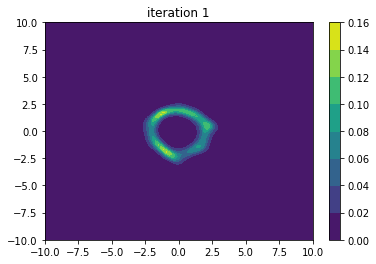

1000 4.100296497344971 -7.049783706665039


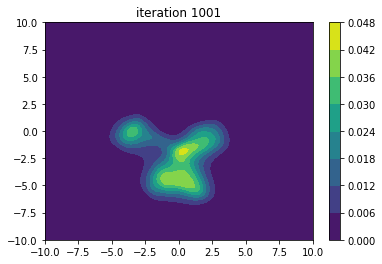

2000 4.139292240142822 -7.113257884979248


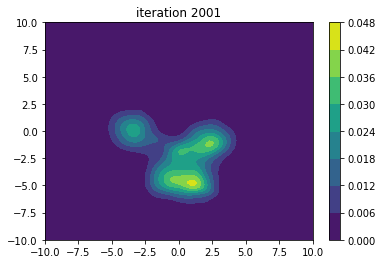

3000 4.181491851806641 -7.138978958129883


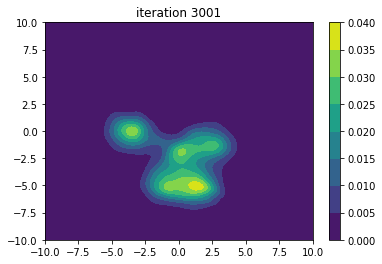

4000 4.05868673324585 -7.098455905914307


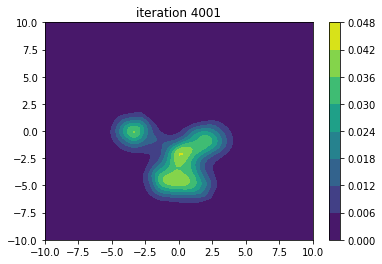

5000 4.1335554122924805 -7.035844802856445


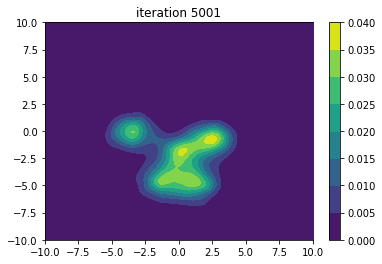

In [30]:
def log_likelihood(h,log_det,distr,base_distr="normal"):
    if base_distr == "logistic":
        prior = distr.log_prob(h).sum(1)
    else:
        prior = distr.log_prob(h)
    return prior+log_det

train_loss = train_mixture(model, optimizer, n_epochs=5001, input_grad=True)

In [31]:
def log_likelihood(z, log_det, device):
    """
        Log likelihood
        Inputs:
        - z
        - $\log|\det J_T(z)| = -\log|\det J_{T^{-1}}(x)|$
    """
    d = z.size(1)
    base_distr = D.MultivariateNormal(torch.zeros(d,device=device),torch.eye(d,device=device))
    prior = base_distr.log_prob(z)
    return prior-log_det

s = symKL(model, gm, 10000, device)
print(s, np.log10(s))

tensor(0.0238) tensor(-1.6237)


In [32]:
L = []
for k in range(10):
    s = symKL(model, gm, 10000, device)
    print(s, np.log10(s))
    L.append(np.log10(s))

tensor(0.0288) tensor(-1.5400)
tensor(0.0229) tensor(-1.6401)
tensor(0.0235) tensor(-1.6281)
tensor(0.0251) tensor(-1.6009)
tensor(0.0271) tensor(-1.5677)
tensor(0.0238) tensor(-1.6234)
tensor(0.0291) tensor(-1.5365)
tensor(0.0251) tensor(-1.6005)
tensor(0.0222) tensor(-1.6529)
tensor(0.0252) tensor(-1.5977)


In [33]:
print(np.mean(L),np.std(L))

-1.5987809 0.037962954


[1] Huang, Chin-Wei, et al. "Convex Potential Flows: Universal Probability Distributions with Optimal Transport and Convex Optimization." arXiv preprint arXiv:2012.05942 (2020).